<h1>Downloading the Data from WRDS</h1>
<hr>

In [2]:
import pandas as pd
import numpy as np
import wrds
from pandas.tseries.offsets import MonthEnd

# Connect to WRDS
conn = wrds.Connection(wrds_username='vthukral')

# ------------------------
# Load CRSP Bond Data
# ------------------------
print('Loading Bond Data...')
bonds = conn.raw_sql("""
    SELECT kycrspid, mcaldt, tmretnua, tmtotout
    FROM crspq.tfz_mth
""")
bonds['mcaldt'] = pd.to_datetime(bonds['mcaldt']) + MonthEnd(0)
bonds = bonds.rename(columns={
    "kycrspid": "idCRSP",
    "mcaldt": "date",
    "tmretnua": "ret",
    "tmtotout": "me"
}).copy()

# Save bonds data
bonds.to_csv('bonds_data.csv', index=False)

# ------------------------
# Load CRSP T-Bill (Risk-Free) Data
# ------------------------
print('Loading T-Bill Data...')
rf = conn.raw_sql("""
    SELECT caldt, t30ret, t90ret
    FROM crspq.mcti
""")
rf['caldt'] = pd.to_datetime(rf['caldt']) + MonthEnd(0)
rf = rf.rename(columns={
    "caldt": "date",
    "t30ret": "rf30",
    "t90ret": "rf90"
}).copy()

# Save risk-free data
rf.to_csv('rf_data.csv', index=False)

# ------------------------
# Close WRDS Connection
# ------------------------
conn.close()
print('Data download complete. Files saved: bonds_data.csv and rf_data.csv')


Enter your WRDS username [vthukral]: vthukral
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
Loading Bond Data...
Loading T-Bill Data...
Data download complete. Files saved: bonds_data.csv and rf_data.csv


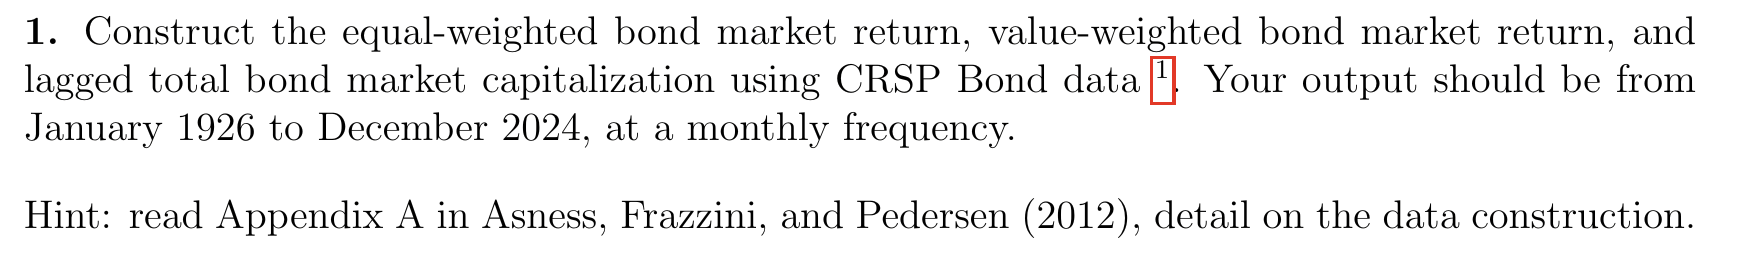

In [79]:
import pandas as pd
import numpy as np

bonds = pd.read_csv('bonds_data.csv')

def PS2_Q1(CRSP_Bonds):
    """
    Constructs Equal-Weighted Return, Value-Weighted Return,
    and Lagged Total Bond Market Capitalization (in millions) with Year and Month columns.

    Inputs:
    - CRSP_Bonds: DataFrame with columns ['idCRSP', 'date', 'ret', 'me']

    Outputs:
    - DataFrame with columns ['Year', 'Month', 'Bond_lag_MV', 'Bond_Ew_Ret', 'Bond_Vw_Ret']
    """

    """Ensure 'date' is datetime"""
    CRSP_Bonds['date'] = pd.to_datetime(CRSP_Bonds['date'])
    
    """Filter the sample period"""
    CRSP_Bonds = CRSP_Bonds.loc[
        (CRSP_Bonds['date'] >= '1926-01-31') & (CRSP_Bonds['date'] <= '2024-12-31')
    ].copy()
    
    """Drop rows with missing returns or market cap"""
    CRSP_Bonds = CRSP_Bonds.dropna(subset=['ret', 'me'])
    
    """Group by month"""
    grouped = CRSP_Bonds.groupby('date')
    
    """Calculate Equal-weighted return"""
    equal_weighted_return = grouped['ret'].mean()
    
    """Calculate Value-weighted return"""
    value_weighted_return = grouped.apply(lambda x: np.average(x['ret'], weights=x['me']))
    
    """Calculate total market capitalization"""
    total_market_cap = grouped['me'].sum()
    
    """Lagged total market cap and scale to millions"""
    lagged_total_market_cap = total_market_cap.shift(1) / 1_000_000

    """Create the result DataFrame"""
    result = pd.DataFrame({
        'Bond_Ew_Ret': equal_weighted_return,
        'Bond_Vw_Ret': value_weighted_return,
        'Bond_lag_MV': lagged_total_market_cap
    })
    
    """Add Year and Month columns from the index (date)"""
    result['Year'] = result.index.year
    result['Month'] = result.index.month

    """Reorder columns to put Year and Month first"""
    result = result[['Year', 'Month', 'Bond_lag_MV', 'Bond_Ew_Ret', 'Bond_Vw_Ret']]

    return result


C:\Users\vikal\AppData\Local\Temp\ipykernel_5652\903751667.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  bonds = pd.read_csv('bonds_data.csv')


In [80]:
Q1_output =  PS2_Q1(bonds)

C:\Users\vikal\AppData\Local\Temp\ipykernel_5652\903751667.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  value_weighted_return = grouped.apply(lambda x: np.average(x['ret'], weights=x['me']))


In [83]:
Q1_output.to_csv('PS2_Q1.csv')

In [44]:
bonds = pd.read_csv('bonds_data.csv')

def PS2_Q1(CRSP_Bonds: pd.DataFrame) -> pd.DataFrame:
    """
    Constructs equal-weighted bond market return, value-weighted bond market return,
    and lagged total bond market capitalization from CRSP bond data.

    Parameters:
        CRSP_Bonds (pd.DataFrame): Raw CRSP bond data with columns ['idCRSP', 'date', 'ret', 'me']

    Returns:
        pd.DataFrame: A dataframe with ['Year', 'Month', 'Bond_lag_MV', 'Bond_Ew_Ret', 'Bond_Vw_Ret']
    """

    """Make a copy of the input"""
    df = CRSP_Bonds.copy()
    
    """Convert 'date' column to datetime format"""
    df['date'] = pd.to_datetime(df['date'])

    """Extract Year and Month for grouping"""
    df['Year'] = df['date'].dt.year
    df['Month'] = df['date'].dt.month

    """Convert 'ret' and 'me' to numeric, forcing errors to NaN"""
    df['ret'] = pd.to_numeric(df['ret'], errors='coerce')
    df['me'] = pd.to_numeric(df['me'], errors='coerce')

    """Lag market value by one month within each bond"""
    df['lag_me'] = df.groupby('idCRSP')['me'].shift(1)

    """Drop rows with missing lagged market values"""
    df = df.dropna(subset=['lag_me'])

    """Group data by Year and Month"""
    monthly = df.groupby(['Year', 'Month'])

    """Calculate Equal-Weighted Bond Return"""
    ew_ret = monthly['ret'].mean().rename("Bond_Ew_Ret")

    """Calculate Value-Weighted Bond Return using lagged market values"""
    vw_ret = monthly.apply(lambda x: np.average(x['ret'], weights=x['lag_me'])).rename("Bond_Vw_Ret")

    """Calculate Lagged Total Bond Market Capitalization (in millions)"""
    lag_mv = (monthly['lag_me'].sum() / 1e6).rename("Bond_lag_MV")

    """Combine all series into a final DataFrame"""
    final_df = pd.concat([lag_mv, ew_ret, vw_ret], axis=1).dropna().reset_index()

    """Restrict to January 1926 to December 2024"""
    final_df = final_df[(final_df['Year'] >= 1926) & (final_df['Year'] <= 2024)]

    return final_df

# Example Usage:
# CRSP_Bonds = pd.read_csv('bonds_PS2.csv', dtype=str, low_memory=False)
# result_df = PS2_Q1(CRSP_Bonds)
# print(result_df.head(10))


C:\Users\vikal\AppData\Local\Temp\ipykernel_5652\2434258098.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  bonds = pd.read_csv('bonds_data.csv')


In [45]:
Q1_output =  PS2_Q1(bonds)

C:\Users\vikal\AppData\Local\Temp\ipykernel_5652\2434258098.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vw_ret = monthly.apply(lambda x: np.average(x['ret'], weights=x['lag_me'])).rename("Bond_Vw_Ret")


In [71]:
Q1_output

,Year,Month,Bond_lag_MV,Bond_Ew_Ret,Bond_Vw_Ret
date,,,,,
1926-01-31,1926,1,NaN,0.005101,0.006829
1926-02-28,1926,2,0.019502,0.003621,0.003844
1926-03-31,1926,3,0.019500,0.003812,0.003583
1926-04-30,1926,4,0.018736,0.004014,0.006486
1926-05-31,1926,5,0.019227,0.002146,0.002629
...,...,...,...,...,...
2024-08-31,2024,8,24.076745,0.010776,0.010137
2024-09-30,2024,9,24.240686,0.010147,0.009613
2024-10-31,2024,10,24.488777,-0.018731,-0.016736


In [49]:
Q1_output.to_csv("PS2_Q1.csv")

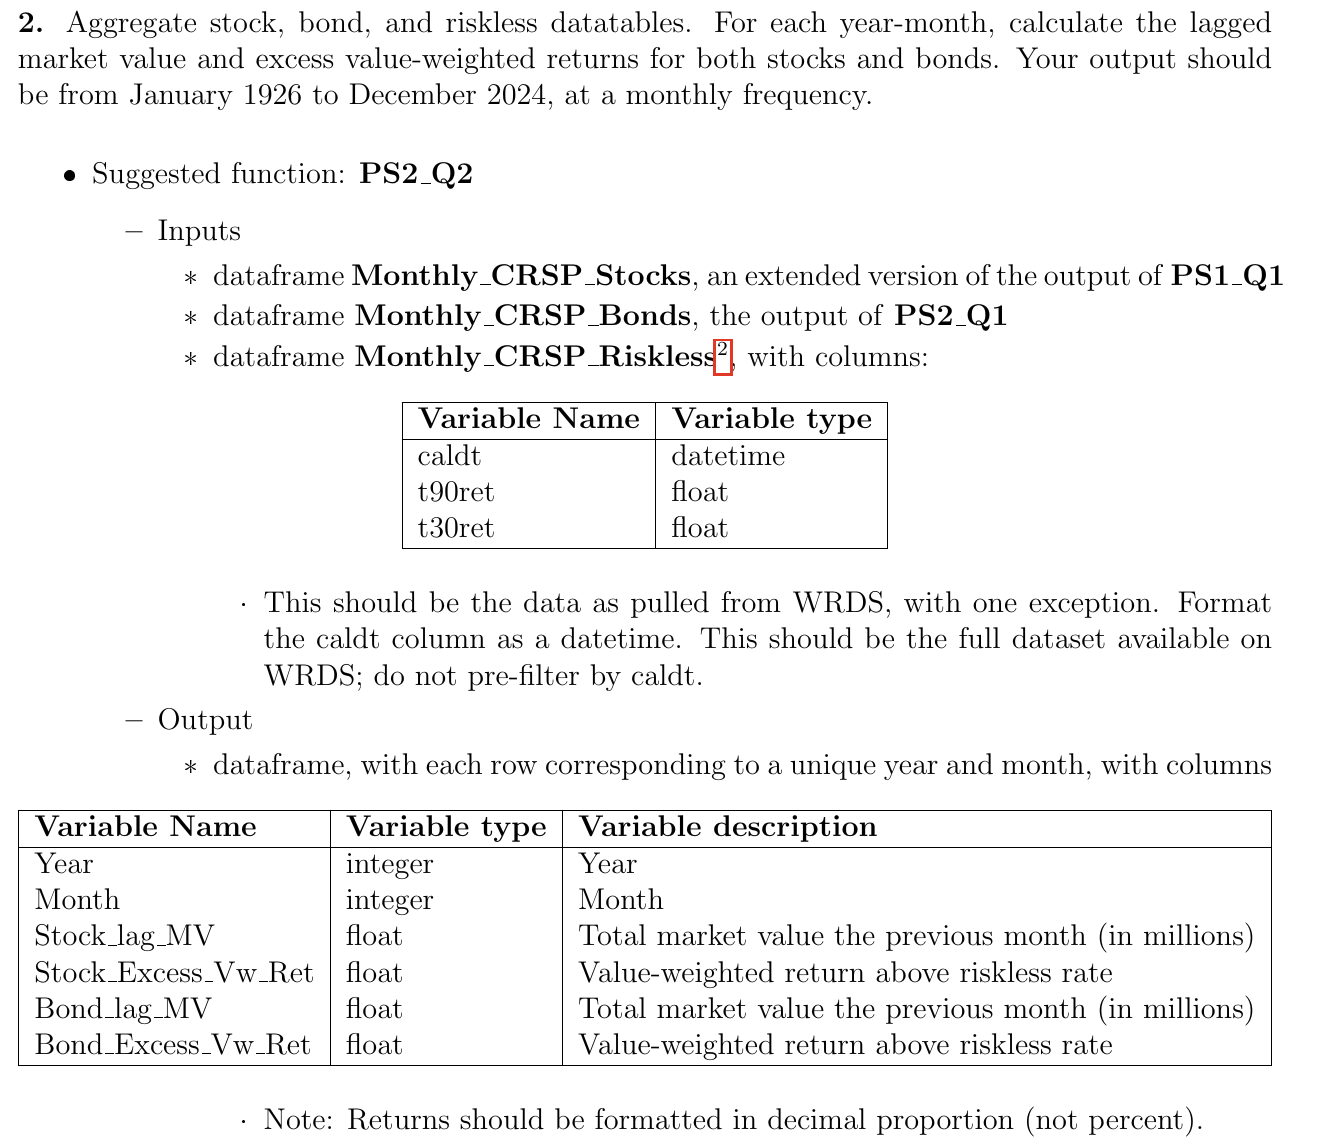

<h1>Downloading the Data from WRDS</h1>
<hr>

In [36]:
import pandas as pd
import numpy as np
import wrds
from pandas.tseries.offsets import MonthEnd

"""
Connect to WRDS
"""
conn = wrds.Connection(wrds_username='vthukral')

"""
Load CRSP Stock Returns
"""
print('Loading CRSP Stock Returns Data...')
crsp_raw = conn.raw_sql("""
    SELECT a.permno, a.permco, a.date, b.shrcd, b.exchcd,
           a.ret, a.retx, a.shrout, a.prc, a.cfacshr
    FROM crspq.msf AS a
    LEFT JOIN crsp.msenames AS b
    ON a.permno = b.permno
    AND b.namedt <= a.date
    AND a.date <= b.nameendt
    WHERE a.date BETWEEN '01/01/1900' AND '12/31/2025'
""")
crsp_raw['date'] = pd.to_datetime(crsp_raw['date']) + MonthEnd(0)
crsp_raw[['permno', 'permco']] = crsp_raw[['permno', 'permco']].astype(int)

"""
Load CRSP Delisting Returns
"""
print('Loading CRSP Delisting Returns Data...')
dlret_raw = conn.raw_sql("""
    SELECT permno, dlret, dlstdt, dlstcd
    FROM crspq.msedelist
""")
dlret_raw['dlstdt'] = pd.to_datetime(dlret_raw['dlstdt'])
dlret_raw['date'] = dlret_raw['dlstdt'] + MonthEnd(0)
dlret_raw['permno'] = dlret_raw['permno'].astype(int)

"""
Load CRSP VW Market Index (Benchmark)
"""
print('Loading CRSP Market Index Data...')
mkt_csrp = conn.raw_sql("""
    SELECT date, VWRETD, totval
    FROM crspq.msi
""")
mkt_csrp['date'] = pd.to_datetime(mkt_csrp['date']) + MonthEnd(0)
mkt_csrp = mkt_csrp.rename(columns={"VWRETD": "mkt_crsp", "totval": "mkt_crsp_mktcap"})

"""
Close WRDS Connection
"""
conn.close()
print('WRDS connection closed.')

"""
Save Raw Files
"""
crsp_raw.to_csv('crsp_raw_PS2.csv', index=False)
dlret_raw.to_csv('dlret_raw_PS2.csv', index=False)
mkt_csrp.to_csv('mkt_csrp_PS2.csv', index=False)

"""
Process and Create Monthly_CRSP_Stocks
"""
print('Processing Monthly CRSP Stocks...')

# Merge stock returns with delisting returns
crsp = crsp_raw.merge(dlret_raw[['permno', 'date', 'dlret']], on=['permno', 'date'], how='left')

# Adjust returns for delisting
crsp['retadj'] = crsp['ret']
mask = ~crsp['dlret'].isnull()
crsp.loc[mask, 'retadj'] = (1 + crsp.loc[mask, 'retadj']) * (1 + crsp.loc[mask, 'dlret']) - 1

# Calculate market capitalization
crsp['me'] = crsp['prc'].abs() * crsp['shrout']

# Filter for valid common stocks
crsp = crsp[
    (crsp['shrcd'].isin([10, 11])) & 
    (crsp['exchcd'].isin([1, 2, 3])) &
    (crsp['prc'].abs() > 0) &
    (crsp['shrout'] > 0) &
    (~crsp['retadj'].isnull())
]

# Group by month
crsp_grouped = crsp.groupby('date')

# Create Monthly CRSP Stocks
Monthly_CRSP_Stocks = pd.DataFrame({
    'Value_Weighted_Return': crsp_grouped.apply(lambda x: np.average(x['retadj'], weights=x['me'])),
    'Total_Market_Cap': crsp_grouped['me'].sum()
}).reset_index()

# Add Year and Month
Monthly_CRSP_Stocks['Year'] = Monthly_CRSP_Stocks['date'].dt.year
Monthly_CRSP_Stocks['Month'] = Monthly_CRSP_Stocks['date'].dt.month

# Save Processed File
Monthly_CRSP_Stocks.to_csv('Monthly_CRSP_Stocks.csv', index=False)

print('Step 1 complete: Files saved - crsp_raw_PS2.csv, dlret_raw_PS2.csv, mkt_csrp_PS2.csv, Monthly_CRSP_Stocks.csv')


Loading library list...
Done
Loading CRSP Stock Returns Data...
Loading CRSP Delisting Returns Data...
Loading CRSP Market Index Data...
WRDS connection closed.
Processing Monthly CRSP Stocks...
Step 1 complete: Files saved - crsp_raw_PS2.csv, dlret_raw_PS2.csv, mkt_csrp_PS2.csv, Monthly_CRSP_Stocks.csv


C:\Users\vikal\AppData\Local\Temp\ipykernel_5652\1518014395.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'Value_Weighted_Return': crsp_grouped.apply(lambda x: np.average(x['retadj'], weights=x['me'])),


<hr>
<h1><b>Step 2:</b> Solve PS2_Q2 — Final Code</h1>
<hr>

In [96]:
import pandas as pd

def PS2_Q2(Monthly_CRSP_Stocks, Monthly_CRSP_Bonds, Monthly_CRSP_Riskless):
    """
    Constructs the final PS2_Q2 DataFrame by aggregating lagged market values and excess returns
    for stocks and bonds from January 1926 to December 2024.

    Inputs:
    - Monthly_CRSP_Stocks: DataFrame with columns ['Year', 'Month', 'Stock lag MV', 'Stock Ew Ret', 'Stock Vw Ret']
    - Monthly_CRSP_Bonds: DataFrame output from PS2_Q1 with columns ['Year', 'Month', 'Bond_lag_MV', 'Bond_Ew_Ret', 'Bond_Vw_Ret']
    - Monthly_CRSP_Riskless: DataFrame with risk-free rates (columns ['date', 'rf30'])

    Output:
    - DataFrame with columns:
      ['Year', 'Month', 'Stock_lag_MV', 'Stock_Excess_Vw_Ret', 'Bond_lag_MV', 'Bond_Excess_Vw_Ret']
    """

    """
    Step 1: Prepare Risk-Free Rate
    Convert risk-free rate dates into Year and Month format.
    """
    Monthly_CRSP_Riskless['date'] = pd.to_datetime(Monthly_CRSP_Riskless['date'])
    Monthly_CRSP_Riskless['Year'] = Monthly_CRSP_Riskless['date'].dt.year
    Monthly_CRSP_Riskless['Month'] = Monthly_CRSP_Riskless['date'].dt.month
    riskless = Monthly_CRSP_Riskless[['Year', 'Month', 'rf30']].copy()

    """
    Step 2: Prepare Stock Data
    Rename columns to match the internal naming convention and merge with risk-free rate.
    """
    df_stocks = Monthly_CRSP_Stocks.copy()
    df_stocks = df_stocks.rename(columns={
        'Stock lag MV': 'Stock_lag_MV',
        'Stock Ew Ret': 'Stock_Ew_Ret',
        'Stock Vw Ret': 'Stock_Vw_Ret'
    })
    df_stocks = df_stocks.merge(riskless, on=['Year', 'Month'], how='left')
    df_stocks['Stock_Excess_Vw_Ret'] = df_stocks['Stock_Vw_Ret'] - df_stocks['rf30']
    df_stocks["Stock_lag_MV"] =df_stocks["Stock_lag_MV"]/1_000_000

    """
    Step 3: Prepare Bond Data
    Merge bond returns with risk-free rate and calculate excess bond returns.
    """
    df_bonds = Monthly_CRSP_Bonds.copy()
    df_bonds = df_bonds.merge(riskless, on=['Year', 'Month'], how='left')
    df_bonds['Bond_Excess_Vw_Ret'] = df_bonds['Bond_Vw_Ret'] - df_bonds['rf30']

    """
    Step 4: Merge Stock and Bond Information
    Merge the processed stock and bond datasets on Year and Month.
    """
    final = df_stocks[['Year', 'Month', 'Stock_lag_MV', 'Stock_Excess_Vw_Ret']].merge(
        df_bonds[['Year', 'Month', 'Bond_lag_MV', 'Bond_Excess_Vw_Ret']],
        on=['Year', 'Month'],
        how='outer'
    )

    return final


In [97]:
Monthly_CRSP_Stocks = pd.read_csv('PS1_Q1.csv')      # Stock data
Monthly_CRSP_Riskless = pd.read_csv('rf_data.csv')    # Risk-free data
Monthly_CRSP_Bonds = pd.read_csv('PS2_Q1.csv')        # Bond data

Q2_output = PS2_Q2(Monthly_CRSP_Stocks, Monthly_CRSP_Bonds, Monthly_CRSP_Riskless)

# Save the output if needed
Q2_output.to_csv('PS2_Q2_output.csv', index=False)
print('Saved PS2_Q2_output.csv successfully.')


Saved PS2_Q2_output.csv successfully.


In [98]:
Q2_output

,Year,Month,Stock_lag_MV,Stock_Excess_Vw_Ret,Bond_lag_MV,Bond_Excess_Vw_Ret
0,1926,1,NaN,NaN,NaN,0.003878
1,1926,2,27.032345,-0.036744,0.019502,0.001076
2,1926,3,26.162084,-0.067653,0.019500,0.000805
3,1926,4,24.506932,0.033663,0.018736,0.003414
4,1926,5,25.296195,0.011907,0.019227,0.002287
...,...,...,...,...,...,...
1183,2024,8,53565.917121,0.016517,24.076745,0.005718
1184,2024,9,54594.988469,0.016805,24.240686,0.004994
1185,2024,10,55717.449769,-0.009705,24.488777,-0.020643
1186,2024,11,55336.413557,0.065003,24.537372,0.003675


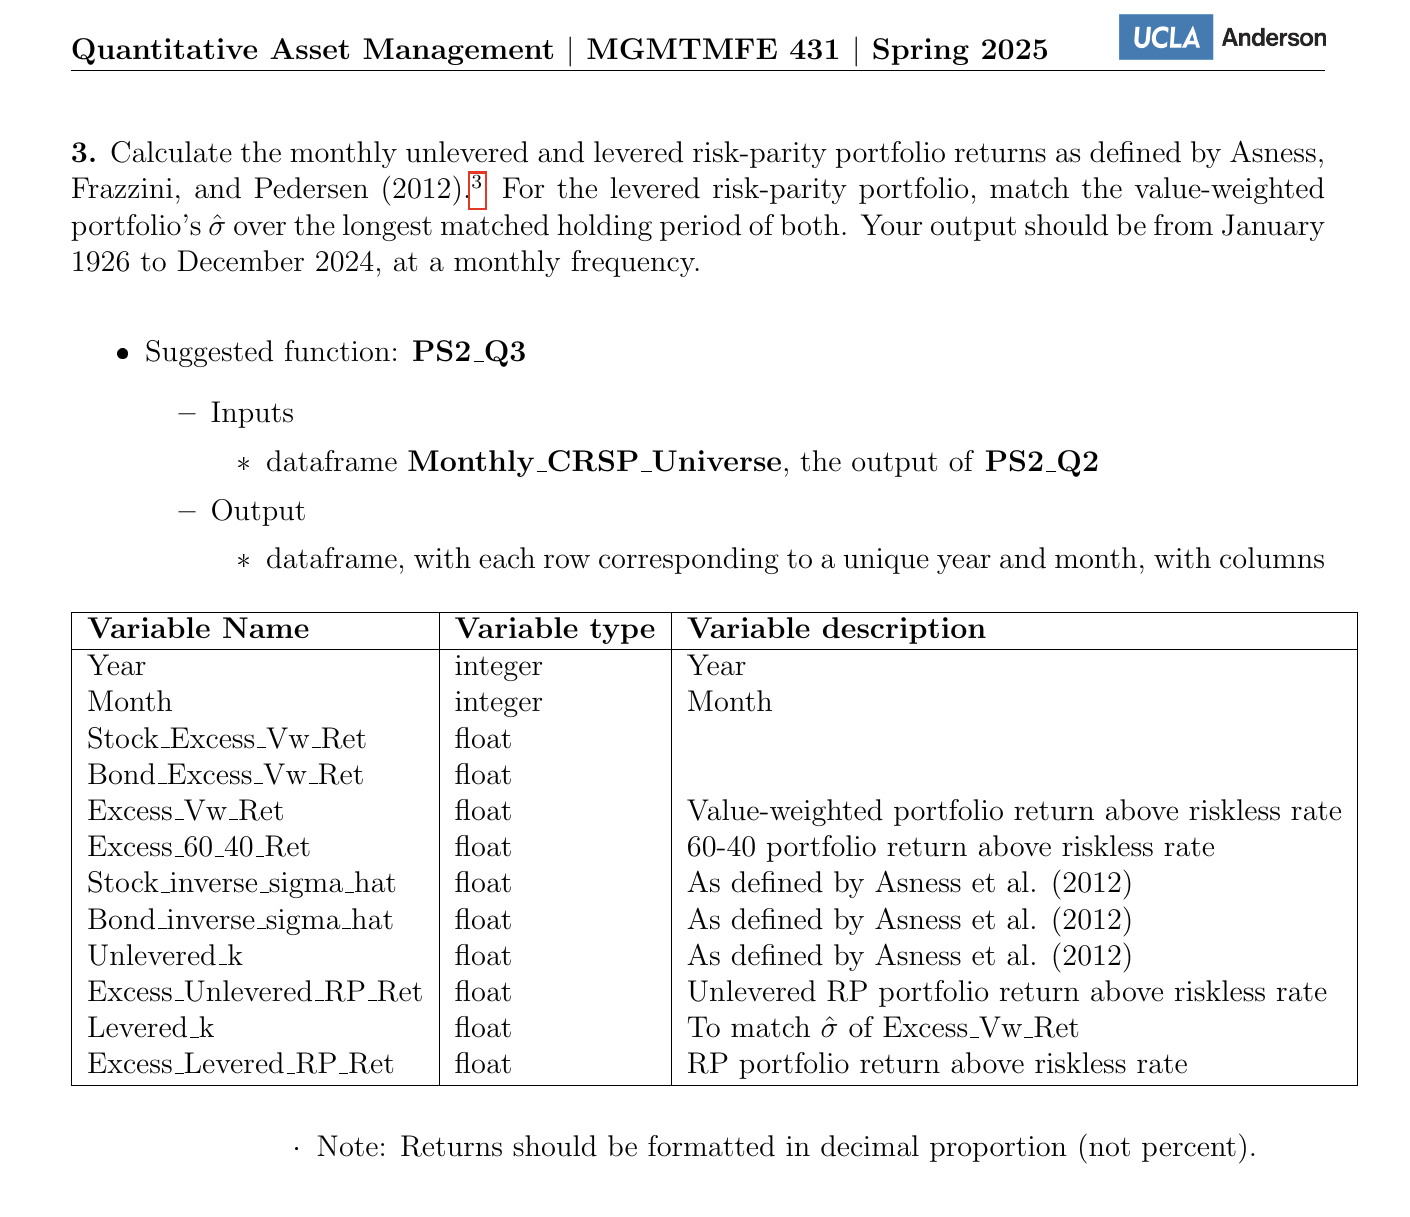

In [99]:
import pandas as pd
import numpy as np

def PS2_Q3(Monthly_CRSP_Universe):
    """
    Constructs unlevered and levered Risk-Parity (RP) portfolio returns 
    based on Monthly_CRSP_Universe (the output from PS2_Q2).

    Inputs:
    - Monthly_CRSP_Universe: DataFrame with columns:
      ['Year', 'Month', 'Stock_lag_MV', 'Stock_Excess_Vw_Ret', 'Bond_lag_MV', 'Bond_Excess_Vw_Ret']

    Outputs:
    - DataFrame with columns:
      ['Year', 'Month', 'Stock_Excess_Vw_Ret', 'Bond_Excess_Vw_Ret',
       'Excess_Vw_Ret', 'Excess_60_40_Ret',
       'Stock_inverse_sigma_hat', 'Bond_inverse_sigma_hat',
       'Unlevered_k', 'Excess_Unlevered_RP_Ret',
       'Levered_k', 'Excess_Levered_RP_Ret']
    """

    """
    Compute rolling volatilities (σ̂) using a 36-month window
    """
    Monthly_CRSP_Universe = Monthly_CRSP_Universe.copy()
    Monthly_CRSP_Universe['Stock_inverse_sigma_hat'] = 1 / Monthly_CRSP_Universe['Stock_Excess_Vw_Ret'].rolling(36).std()
    Monthly_CRSP_Universe['Bond_inverse_sigma_hat'] = 1 / Monthly_CRSP_Universe['Bond_Excess_Vw_Ret'].rolling(36).std()

    """
    Compute value-weighted portfolio returns (excess) and 60/40 portfolio returns (excess)
    """
    vw_excess_ret = (Monthly_CRSP_Universe['Stock_lag_MV'] * Monthly_CRSP_Universe['Stock_Excess_Vw_Ret'] +
                     Monthly_CRSP_Universe['Bond_lag_MV'] * Monthly_CRSP_Universe['Bond_Excess_Vw_Ret']) / \
                    (Monthly_CRSP_Universe['Stock_lag_MV'] + Monthly_CRSP_Universe['Bond_lag_MV'])
    Monthly_CRSP_Universe['Excess_Vw_Ret'] = vw_excess_ret

    Monthly_CRSP_Universe['Excess_60_40_Ret'] = 0.6 * Monthly_CRSP_Universe['Stock_Excess_Vw_Ret'] + \
                                                0.4 * Monthly_CRSP_Universe['Bond_Excess_Vw_Ret']

    """
    Compute unlevered RP portfolio returns
    """
    inverse_vol_sum = Monthly_CRSP_Universe['Stock_inverse_sigma_hat'] + Monthly_CRSP_Universe['Bond_inverse_sigma_hat']
    Monthly_CRSP_Universe['Unlevered_k'] = 1 / inverse_vol_sum

    Monthly_CRSP_Universe['Excess_Unlevered_RP_Ret'] = Monthly_CRSP_Universe['Unlevered_k'] * (
        Monthly_CRSP_Universe['Stock_inverse_sigma_hat'] * Monthly_CRSP_Universe['Stock_Excess_Vw_Ret'] +
        Monthly_CRSP_Universe['Bond_inverse_sigma_hat'] * Monthly_CRSP_Universe['Bond_Excess_Vw_Ret']
    )

    """
    Compute levered RP portfolio returns (leveraged to match Vw portfolio σ̂)
    """
    vol_Vw = Monthly_CRSP_Universe['Excess_Vw_Ret'].rolling(36).std()
    vol_RP = Monthly_CRSP_Universe['Excess_Unlevered_RP_Ret'].rolling(36).std()
    Monthly_CRSP_Universe['Levered_k'] = vol_Vw / vol_RP

    Monthly_CRSP_Universe['Excess_Levered_RP_Ret'] = Monthly_CRSP_Universe['Levered_k'] * Monthly_CRSP_Universe['Excess_Unlevered_RP_Ret']

    """
    Final output dataframe
    """
    result = Monthly_CRSP_Universe[[
        'Year', 'Month',
        'Stock_Excess_Vw_Ret', 'Bond_Excess_Vw_Ret',
        'Excess_Vw_Ret', 'Excess_60_40_Ret',
        'Stock_inverse_sigma_hat', 'Bond_inverse_sigma_hat',
        'Unlevered_k', 'Excess_Unlevered_RP_Ret',
        'Levered_k', 'Excess_Levered_RP_Ret'
    ]].copy()

    return result


In [107]:
Q3_output = PS2_Q3(Q2_output)
Q3_output

,Year,Month,Stock_Excess_Vw_Ret,Bond_Excess_Vw_Ret,Excess_Vw_Ret,Excess_60_40_Ret,Stock_inverse_sigma_hat,Bond_inverse_sigma_hat,Unlevered_k,Excess_Unlevered_RP_Ret,Levered_k,Excess_Levered_RP_Ret
0,1926,1,NaN,0.003878,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,1926,2,-0.036744,0.001076,-0.036717,-0.021616,NaN,NaN,1.0,NaN,NaN,NaN
2,1926,3,-0.067653,0.000805,-0.067602,-0.040270,NaN,NaN,1.0,NaN,NaN,NaN
3,1926,4,0.033663,0.003414,0.033640,0.021564,NaN,NaN,1.0,NaN,NaN,NaN
4,1926,5,0.011907,0.002287,0.011900,0.008059,NaN,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1183,2024,8,0.016517,0.005718,0.016513,0.012198,19.299225,67.939401,1.0,0.008107,2.699263,0.021884
1184,2024,9,0.016805,0.004994,0.016800,0.012081,19.537989,67.671823,1.0,0.007640,2.667851,0.020383
1185,2024,10,-0.009705,-0.020643,-0.009710,-0.014080,19.925321,66.407814,1.0,-0.018119,2.598028,-0.047073
1186,2024,11,0.065003,0.003675,0.064975,0.040471,19.580052,66.493317,1.0,0.017626,2.608054,0.045969


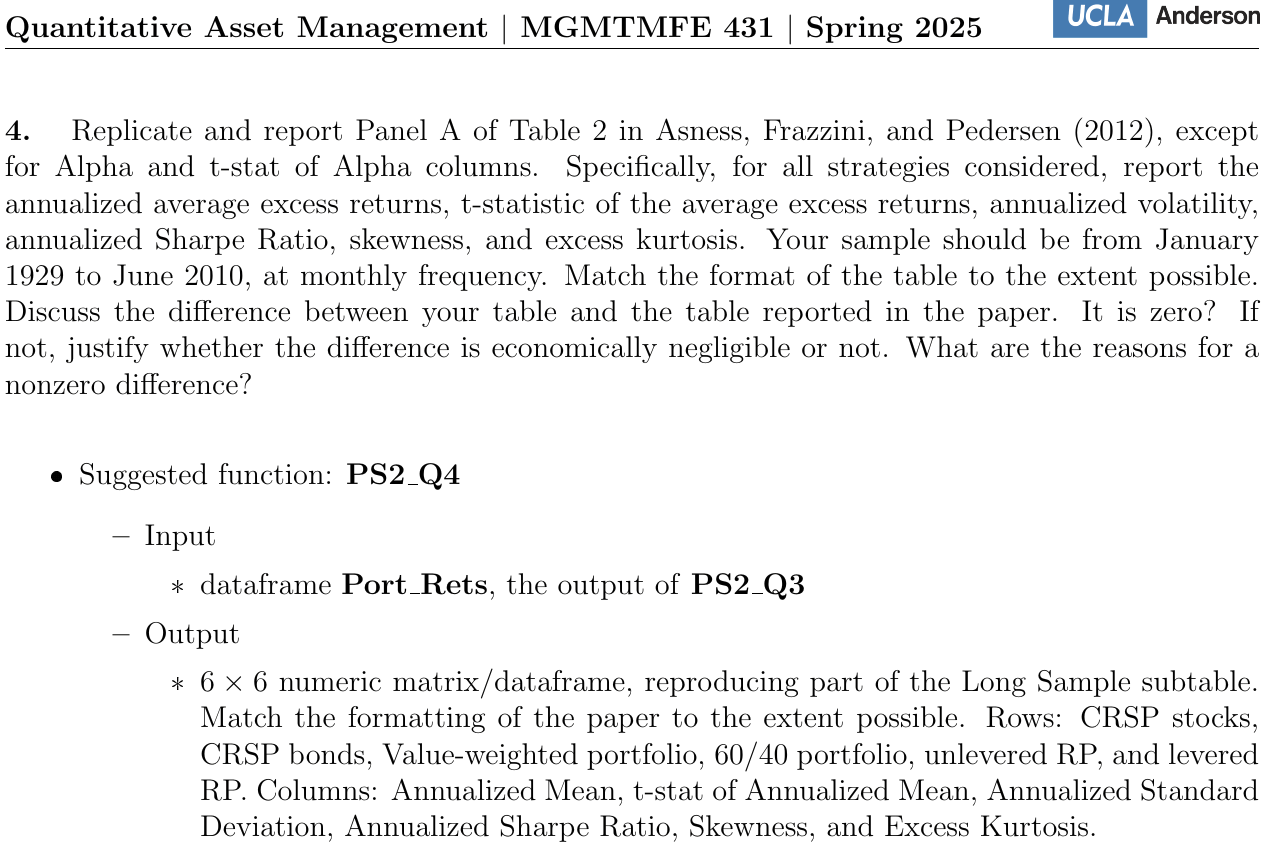

In [108]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

def PS2_Q4(Port_Rets):
    """
    Computes performance statistics for different portfolios from January 1929 to June 2010.

    Inputs:
    - Port_Rets: DataFrame, the output from PS2_Q3 containing portfolio excess returns.

    Outputs:
    - stats_table: DataFrame, a 6 × 6 table reporting Annualized Mean, t-statistic of Mean,
      Annualized Volatility, Annualized Sharpe Ratio, Skewness, and Excess Kurtosis.
    """

    """Restrict the sample"""
    Port_Rets = Port_Rets.copy()
    Port_Rets['date'] = pd.to_datetime(Port_Rets['Year'].astype(str) + '-' + Port_Rets['Month'].astype(str)) + pd.offsets.MonthEnd(0)
    Port_Rets = Port_Rets[(Port_Rets['date'] >= '1929-01-31') & (Port_Rets['date'] <= '2010-06-30')]

    """Identify the portfolio columns"""
    port_cols = [
        'Stock_Excess_Vw_Ret',
        'Bond_Excess_Vw_Ret',
        'Excess_Vw_Ret',
        'Excess_60_40_Ret',
        'Excess_Unlevered_RP_Ret',
        'Excess_Levered_RP_Ret'
    ]

    """Initialize dictionary to store results"""
    results = {}

    """Calculate metrics for each portfolio"""
    for col in port_cols:
        rets = Port_Rets[col].dropna()
        n = len(rets)

        ann_mean = 12 * rets.mean()
        ann_vol = np.sqrt(12) * rets.std()
        t_stat = ann_mean / (rets.std() / np.sqrt(n))
        sharpe = ann_mean / ann_vol
        skewness = skew(rets)
        ex_kurt = kurtosis(rets)  # Already excess kurtosis (subtracts 3)

        results[col] = [
            ann_mean,
            t_stat,
            ann_vol,
            sharpe,
            skewness,
            ex_kurt
        ]

    """Create final DataFrame"""
    stats_table = pd.DataFrame(results, index=[
        'Annualized Mean',
        't-stat of Mean',
        'Annualized Volatility',
        'Annualized Sharpe Ratio',
        'Skewness',
        'Excess Kurtosis'
    ]).T

    return stats_table


In [109]:
Q4_output = PS2_Q4(Q3_output)
Q4_output

,Annualized Mean,t-stat of Mean,Annualized Volatility,Annualized Sharpe Ratio,Skewness,Excess Kurtosis
Stock_Excess_Vw_Ret,0.067450,38.303674,0.190765,0.353574,0.229409,7.642783
Bond_Excess_Vw_Ret,0.013910,53.816348,0.028000,0.496769,0.214356,4.087531
Excess_Vw_Ret,0.067363,38.285007,0.190613,0.353402,0.227733,7.634805
Excess_60_40_Ret,0.046034,42.864344,0.116343,0.395673,0.239658,7.399356
Excess_Unlevered_RP_Ret,0.021024,64.604804,0.035255,0.596355,0.109309,2.684188
Excess_Levered_RP_Ret,0.122175,69.732333,0.186378,0.655523,0.024889,5.658504
